# Hands-On: CopTwitter

In [1]:
import pandas as pd
from tqdm import tqdm # Fortschrittsanzeige für pandas
tqdm.pandas() 

### Import der Daten
Legt die Dateien, die in dem Slack-Channel gepostet wurden, unter `data` ab.

In [2]:
tweets = pd.read_csv('./data/tweet.csv', parse_dates= ['created_at'],encoding='utf-8-sig')
# entities = pd.read_csv('./data/entity.csv')
# users = pd.read_csv('./data/user.csv')

In [3]:
tweets.head()

id                                         tweet_text  \
0  1321021123463663616  @mahanna196 Da die Stadt keine Ausnahme für Ra...   
1  1321023114071969792  #Zeugengesucht\nDie Hintergründe zu dem Tötung...   
2  1321025127388188673  RT @bka: EUROPE´S MOST WANTED – Sexualstraftät...   
3  1321028108665950208  @StrupeitVolker Wir verstehen nicht so recht w...   
4  1321029199998656513  Wir unterstützen das @bka bei der #Öffentlichk...   

           created_at             user_id  like_count  retweet_count  \
0 2020-10-27 09:29:13  778895426007203840         2.0            1.0   
1 2020-10-27 09:37:08          2397974054        20.0           24.0   
2 2020-10-27 09:45:08          2397974054         NaN            NaN   
3 2020-10-27 09:56:59          2810902381        55.0            2.0   
4 2020-10-27 10:01:19           223758384        16.0            9.0   

   reply_count  quote_count  
0          2.0          0.0  
1          4.0          1.0  
2          NaN          NaN  
3          3.0          0.0  
4          5.0          0.0

## Preprocessing

#### Fehlende Werte

Die folgende Methode zeigt an, in welchen Spalten sich Null-Werte befinden.

In [4]:
def missing_values(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent_1 = df.isnull().sum() / df.isnull().count() * 100
  percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
  missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
  return missing_data

In [5]:
missing_values(tweets)

Total    %
like_count      1340  9.7
retweet_count   1340  9.7
reply_count     1340  9.7
quote_count     1340  9.7
id                 0  0.0
tweet_text         0  0.0
created_at         0  0.0
user_id            0  0.0

#### Löschen nicht benötigter Spalten

Vorerst benötigen wir nur die Tweet-ID, den Text, das Erstellungsdatum und die User-ID, deshalb entfernen wir die anderen Spalten.

In [6]:
tweets.drop(columns=['like_count', 'retweet_count', 'reply_count', 'quote_count'])

id                                         tweet_text  \
0      1321021123463663616  @mahanna196 Da die Stadt keine Ausnahme für Ra...   
1      1321023114071969792  #Zeugengesucht\nDie Hintergründe zu dem Tötung...   
2      1321025127388188673  RT @bka: EUROPE´S MOST WANTED – Sexualstraftät...   
3      1321028108665950208  @StrupeitVolker Wir verstehen nicht so recht w...   
4      1321029199998656513  Wir unterstützen das @bka bei der #Öffentlichk...   
...                    ...                                                ...   
13798  1338771029007667201  @PaulvonMessel Für all diese Fragen bzw. deren...   
13799  1338774582610767873  Falls Sie am Wochenende unvermittelt Lust auf ...   
13800  1338774887612243968  RT @LKA_RLP: Wir hätten da noch einen Tipp für...   
13801  1338774967413043201  RT @innen_rlp: 📉#Kriminalitätsstatistik: "Stra...   
13802  1338775143880024068  Öffentlichkeitsfahndung nach 63-jähriger Frau ...   

               created_at             user_id  
0     2020-10-27 09:29:13  778895426007203840  
1     2020-10-27 09:37:08          2397974054  
2     2020-10-27 09:45:08          2397974054  
3     2020-10-27 09:56:59          2810902381  
4     2020-10-27 10:01:19           223758384  
...                   ...                 ...  
13798 2020-12-15 09:01:01  760414297033961474  
13799 2020-12-15 09:15:08          2389373569  
13800 2020-12-15 09:16:21  859377350802386944  
13801 2020-12-15 09:16:40  859377350802386944  
13802 2020-12-15 09:17:22          2987007761  

[13803 rows x 4 columns]

#### Tokenisierung und Bereinigung

Da es hier erst einmal um die Veranschaulichung geht und die Vorverarbeitung von 13.000 sehr lange dauern würde, nehmen wir nur die ersten 100 Tweets.

In [7]:
tweets = tweets.head(100)

Die folgende Methode `clean_text` benutzt die NLP-Bibliothek `spacy`, um aus den Tweets Token (einzelne Wörter) zu generieren, das Lemma eines Wortes zu ermitteln sowie Stoppwörter/Satzzeichen zu entfernen.

In [8]:
import spacy
from string import punctuation

nlp = spacy.load("de_core_news_lg")

def clean_tweet(text):
    doc = nlp(text)
    token_list = []
    
    for token in doc:
        if (token.text not in punctuation) and (token.is_stop is False):
            token_list.append(token.lemma_)
        else:
            pass
    return ' '.join(token_list)

In [9]:
tweets['tweet_text'] = tweets['tweet_text'].progress_apply(lambda text: clean_tweet(text))

100%|██████████| 100/100 [00:00<00:00, 121.51it/s]


`encode` kodiert den Tweet in UTF-8 und entfernt Zeichen, die andere Zeichensetzungen eingefügt haben.

In [10]:
import unicodedata

def encode(text):
    return unicodedata.normalize(u'NFKD', text).encode('ascii', 'ignore').decode('utf8')

In [11]:
tweets['tweet_text'] = tweets['tweet_text'].progress_apply(lambda text: encode(text))

100%|██████████| 100/100 [00:00<00:00, 114068.64it/s]


Das Resultat sieht so aus: 

In [12]:
tweets.head()

id                                         tweet_text  \
0  1321021123463663616  @mahanna196 Stadt Ausnahme Radfahrer auffuhren...   
1  1321023114071969792  Zeugengesucht \n Hintergrund Totungsdelikt Ges...   
2  1321025127388188673  RT @bka EUROPE   S MOST WANTED  Sexualstraftat...   
3  1321028108665950208          @StrupeitVolker verstehen kennen Glashaus   
4  1321029199998656513  unterstutzen @bka Offentlichkeitsfahndung Tatv...   

           created_at             user_id  like_count  retweet_count  \
0 2020-10-27 09:29:13  778895426007203840         2.0            1.0   
1 2020-10-27 09:37:08          2397974054        20.0           24.0   
2 2020-10-27 09:45:08          2397974054         NaN            NaN   
3 2020-10-27 09:56:59          2810902381        55.0            2.0   
4 2020-10-27 10:01:19           223758384        16.0            9.0   

   reply_count  quote_count  
0          2.0          0.0  
1          4.0          1.0  
2          NaN          NaN  
3          3.0          0.0  
4          5.0          0.0

Damit ist das einfache Preprocessing abgeschlossen. Jetzt können wir mit der Auswertung beginnen.

## Auswertung

### Mögliche Fragen

- Wie oft spricht die Polizei andere Nutzer direkt an?
- Wie oft klingt sich die Polizei in Debatten ein? (die Benutzung von Hashtags)
- Wie oft retweetet die Polizei?
- Welche Polizeireviere sind besonders aktiv? (user_ids zählen)

#### Wie oft spricht die Polizei andere Nutzer direkt an?

In [13]:
def count_at_char(text):
    return text.count('@')

In [14]:
tweets['number_mentions'] = tweets['tweet_text'].apply(lambda text: count_at_char(text))

In [15]:
tweets.sort_values(by=['number_mentions'], ascending=False)

id                                         tweet_text  \
81  1321092048926187525  @Polizei_MH @Nino_Pandari @RiotAward Hallo @Po...   
33  1321060298514698242  @Tine_Singstar @PolizeiRT @PolizeiMuenchen LKA...   
74  1321089697263820804  @Tine_Singstar @PolizeiRT @PolizeiHamburg gern...   
54  1321078197136613376  @Nino_Pandari @Polizei_MH @RiotAward Hey Nino ...   
60  1321081295196311554  @Tine_Singstar @PolizeiRT @PolizeiMuenchen fal...   
..                  ...                                                ...   
14  1321035942300364800  Wallanlagen innerhalb Walls Innenstadt Albanip...   
61  1321081301882064897  Gestern fuhren Verkehrspolizeiinspektion Leipz...   
62  1321081433721634816  Fokus stehen Freihalten Radfahrstreifen ordnun...   
27  1321052259560640512  Freitag Stadt Nurnberg stadtische Allgemeinver...   
50  1321073756278849540  Offentlichkeitsfahndung \n 68-jahriger Rollstu...   

            created_at             user_id  like_count  retweet_count  \
81 2020-10-27 14:11:03          2389142300         6.0            0.0   
33 2020-10-27 12:04:53          2904886151         2.0            0.0   
74 2020-10-27 14:01:43          2810902381         1.0            0.0   
54 2020-10-27 13:16:01          2389142300         7.0            0.0   
60 2020-10-27 13:28:19          2904886151         1.0            0.0   
..                 ...                 ...         ...            ...   
14 2020-10-27 10:28:06  772751356230823936        11.0            1.0   
61 2020-10-27 13:28:21           223758384        32.0            2.0   
62 2020-10-27 13:28:52           223758384        11.0            1.0   
27 2020-10-27 11:32:57  800718568572612608        29.0           13.0   
50 2020-10-27 12:58:22          2904886151        21.0           42.0   

    reply_count  quote_count  number_mentions  
81          1.0          0.0                4  
33          1.0          0.0                3  
74          0.0          0.0                3  
54          3.0          0.0                3  
60          0.0          0.0                3  
..          ...          ...              ...  
14          0.0          1.0                0  
61          4.0          2.0                0  
62          2.0          0.0                0  
27          3.0          1.0                0  
50          0.0          3.0                0  

[100 rows x 9 columns]

In [16]:
tweets['number_mentions'].sum()

56

### Sentiment-Analyse

Für den Abschluss bestimmen wir noch das Sentiment eines jeden Tweets mithilfe eines auf einem deutschen Korpus vortrainierten BERT-Models.

In [17]:
from germansentiment import SentimentModel # siehe https://huggingface.co/oliverguhr/german-sentiment-bert

model = SentimentModel()

In [18]:
tweets['sentiment'] = tweets['tweet_text'].progress_apply(lambda text: model.predict_sentiment([text])[0])

100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


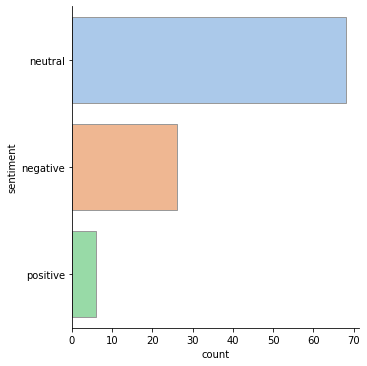

In [19]:
import seaborn as sns

sns.catplot(y="sentiment", kind="count",
            palette="pastel", edgecolor=".6",
            data=tweets)